In [141]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize

In [142]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

tf.test.gpu_device_name() 

'/device:GPU:0'

In [143]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("images_aug"):
    img_path = glob.glob(os.path.join(directory_path, '*.png'))
    img_path.sort()
    for i in img_path:
        #print(i)
        img = cv2.imread(i, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("labels_aug"):
    mask_path = glob.glob(os.path.join(directory_path, '*.png'))
    mask_path.sort()
    for j in mask_path:
        #print(j)
        mask = cv2.imread(j, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)


#Use customary x_train and y_train variables
X = train_images
#X = np.expand_dims(X, axis=3) 
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary..

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


(256, 256, 3)
(256, 256, 3)
(256, 256, 1)
(256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

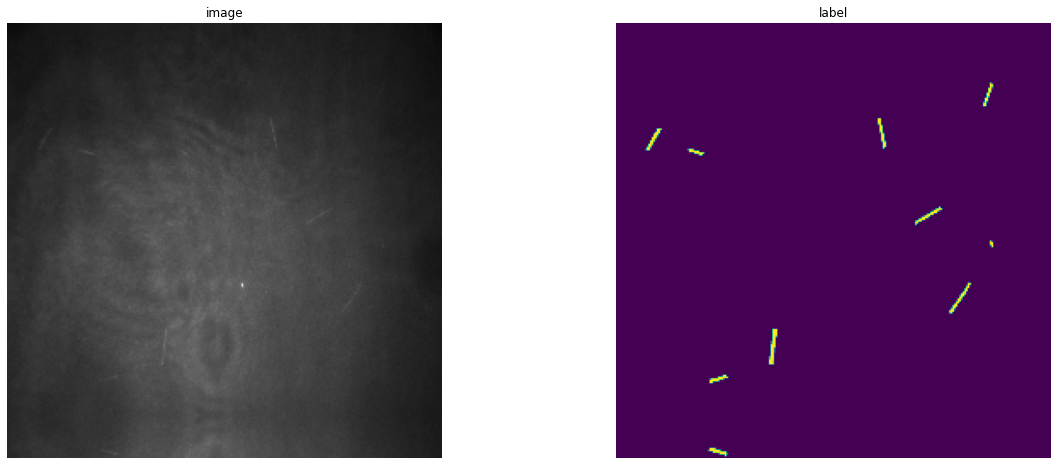

In [144]:
#Sanity check, view few mages

imgsize1 = x_train[0].shape
print(imgsize1)
imgsize2 = x_val[0].shape
print(imgsize2)
imgsize3 = y_train[0].shape
print(imgsize3)
imgsize4 = y_val[0].shape
print(imgsize4)

import random
image_number = random.randint(0, len(x_train))

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax[0].imshow(x_train[image_number])
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(y_train[image_number])
ax[1].set_title('label')
ax[1].axis('off')

In [145]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

print(model.summary())


history=model.fit(x_train, 
          y_train,
          batch_size=8, 
          epochs=10,
          verbose=1,
          validation_data=(x_val, y_val))

e, None, None, 2 0           stage3_unit5_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_568 (ZeroPadding (None, None, None, 2 0           stage3_unit5_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit5_conv1 (Conv2D)     (None, None, None, 2 589824      zero_padding2d_568[0][0]         
__________________________________________________________________________________________________
stage3_unit5_bn2 (BatchNormaliz (None, None, None, 2 1024        stage3_unit5_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit5_relu2 (Activation) (None, None, None, 2 0           stage3_unit5_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_569 (ZeroPadding (None, None, N

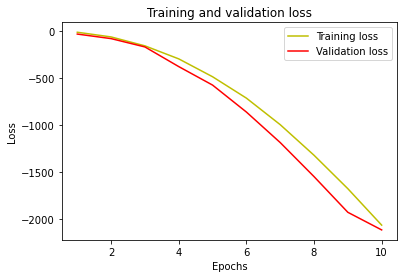

In [146]:
#accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save("MT_semantic_segmantation_model.h5")

(-0.5, 255.5, 255.5, -0.5)

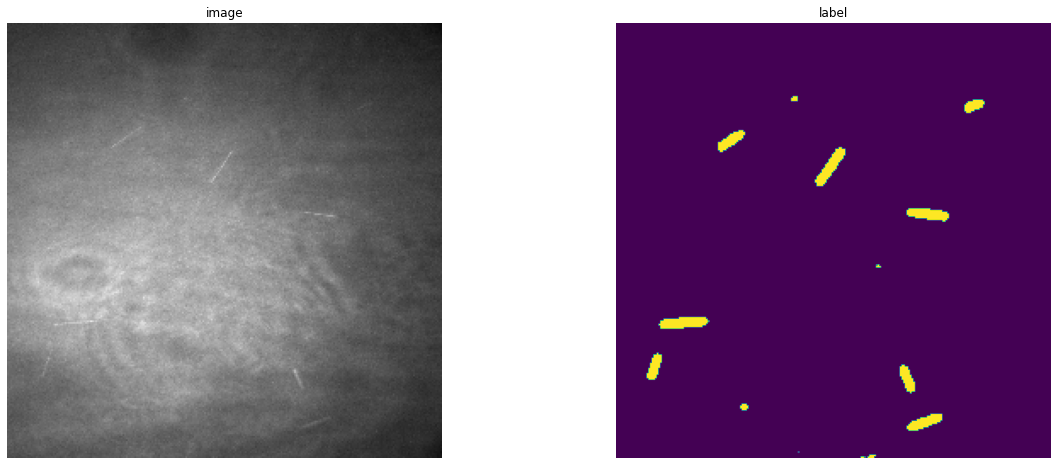

In [151]:
from tensorflow import keras
test_model = keras.models.load_model("MT_semantic_segmantation_model.h5", compile=False)
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('000_30_png/200818_xb_reaction2_6um003c1t030.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
#test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_image = np.expand_dims(test_img, axis=0)

prediction = test_model.predict(test_image)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax[0].imshow(test_img)
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(prediction_image)
ax[1].set_title('label')
ax[1].axis('off')
#plt.imsave('segmented/test0_segmented.png', prediction_image, cmap='gray')